In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=20
CHANNELS=3
EPOCHS=40

In [3]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Fire Detection",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4093 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Fire', 'Non-Fire']

In [5]:
len(dataset)

205

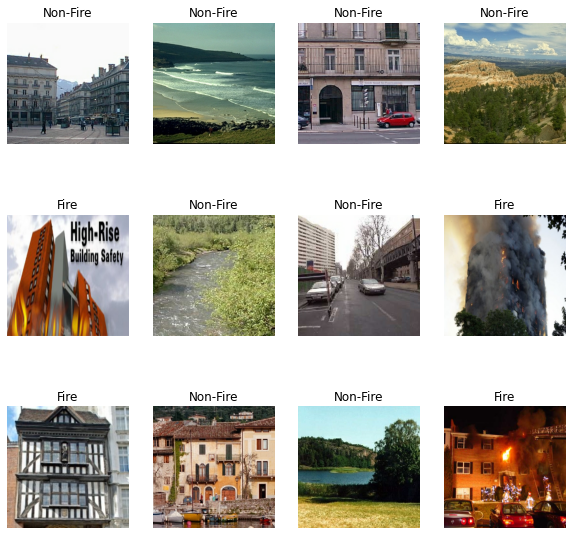

In [6]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

205

In [8]:
#80%==> training
#20%==>10% validation, 10% test

In [9]:
train_size=0.8
len(dataset)*train_size

164.0

In [10]:
train_ds=dataset.take(102)
len(train_ds)

102

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

151

In [12]:
val_size=0.1
len(dataset)*val_size

20.5

In [13]:
val_ds=test_ds.take(12)
len(val_ds)

12

In [14]:
test_ds=test_ds.skip(12)
len(test_ds)

139

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

164

In [18]:
len(val_ds)

20

In [19]:
len(test_ds)


21

In [20]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#Resizing and scaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)#.prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
#Model Architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (20, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (20, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (20, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (20, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (20, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (20, 60, 60, 64)         

In [26]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
164/164 [==============================] - 334s 2s/step - loss: 0.5405 - accuracy: 0.7213 - val_loss: 0.5560 - val_accuracy: 0.7375
Epoch 2/40
164/164 [==============================] - 300s 1s/step - loss: 0.4789 - accuracy: 0.7678 - val_loss: 0.4347 - val_accuracy: 0.7900
Epoch 3/40
164/164 [==============================] - 288s 1s/step - loss: 0.4524 - accuracy: 0.7883 - val_loss: 0.3817 - val_accuracy: 0.8475
Epoch 4/40
164/164 [==============================] - 256s 1s/step - loss: 0.4248 - accuracy: 0.7984 - val_loss: 0.3367 - val_accuracy: 0.8575
Epoch 5/40
164/164 [==============================] - 233s 1s/step - loss: 0.3561 - accuracy: 0.8442 - val_loss: 0.3110 - val_accuracy: 0.8500
Epoch 6/40
164/164 [==============================] - 349s 2s/step - loss: 0.3426 - accuracy: 0.8518 - val_loss: 0.5402 - val_accuracy: 0.7750
Epoch 7/40
164/164 [==============================] - 292s 1s/step - loss: 0.2936 - accuracy: 0.8784 - val_loss: 0.2922 - val_accuracy: 0.8700

In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
scores

# Plotting Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Running Prediction on Sample Image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[3].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[3])])

In [ ]:
#Function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
#Saving the Model
import os
model_version=max([int(i) for i in os.listdir(r"C:\Users\Acer\trial 1\models") + [0]])+1
model.save(f"../models/{model_version}")